In [178]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

from ipywidgets import interact 

#Modelo
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
df = pd.read_csv('data/Modelar_UH2020.txt', sep="|", index_col='ID', encoding='utf-8')
print("Tamaño del conjunto de datos:  %d" % df.shape[0])
print("Número de variables: %d" % df.shape[1])
if df.index.is_unique:
    print('El índice es único.')
else:
    print('Los índices están duplicados.')

Tamaño del conjunto de datos:  103230
Número de variables: 55
El índice es único.


In [3]:
def process_cadastralquality(value):
    dic = {'A': 11, 'B': 10, 'C': 9}
    if value in dic:
        return dic[value]
    else:
        try:
            return 9 - int(value)
        except ValueError:
            return np.nan
        
def process_cadastral(df):
    df['CADASTRALQUALITYID'] = df['CADASTRALQUALITYID'].apply(process_cadastralquality)

In [4]:
process_cadastral(df)

In [5]:
df = df.dropna()

In [6]:
X = df.drop(columns=['CLASE']).copy()
y = df['CLASE'].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, stratify=y, shuffle=True, random_state=10)

df_modelar = X_train.merge(y_train, on='ID')
df_modelar_new = X_val.merge(y_val, on='ID')

print("Tamaño del conjunto de datos disponibles: ", len(df_modelar))
print("Tamaño del conjunto de nuevos datos: ", len(df_modelar_new))

Tamaño del conjunto de datos disponibles:  87728
Tamaño del conjunto de nuevos datos:  15482


In [7]:
list_class_order = ['RESIDENTIAL', 'PUBLIC', 'RETAIL', 'OFFICE', 'INDUSTRIAL', 'AGRICULTURE', 'OTHER']

## Distancia al centro

In [8]:
center_x = df_modelar['X'].sum()/len(df_modelar['X'])
center_y = df_modelar['Y'].sum()/len(df_modelar['Y'])

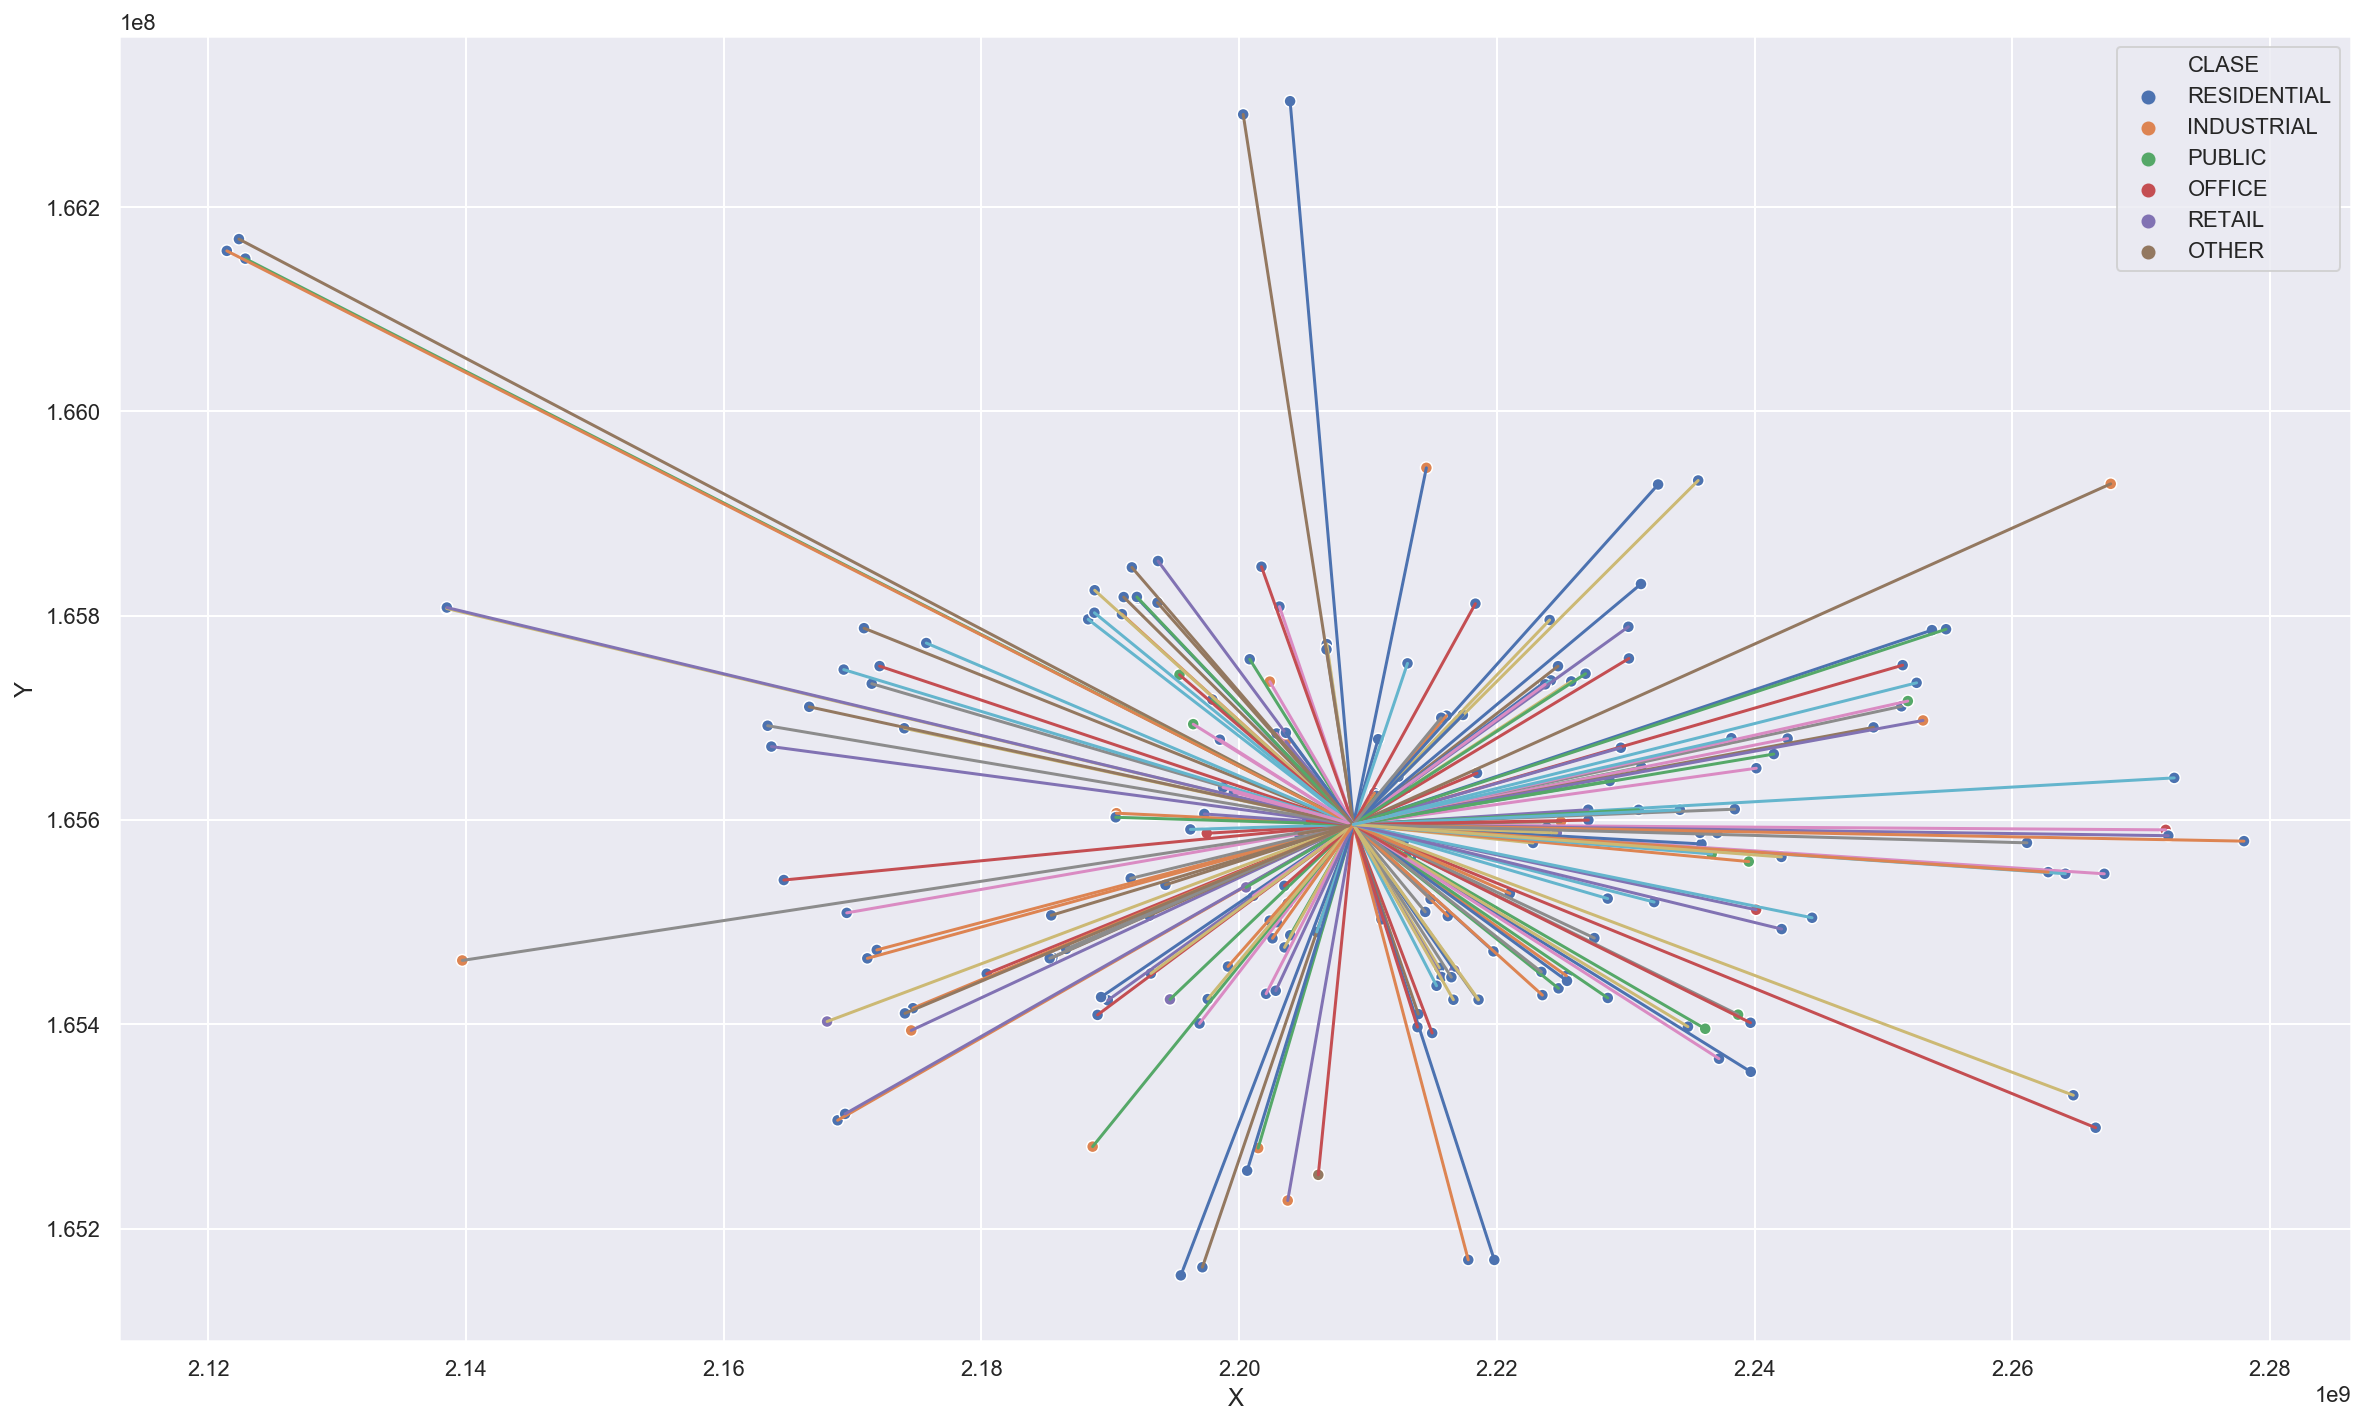

In [11]:
plt.figure(figsize=(20,12))
for i in range(200):
    point1 = [df_modelar.iloc[i]['X'], df_modelar.iloc[i]['Y']]
    point2 = [center_x, center_y]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values)
sns.scatterplot(df_modelar['X'][:200], df_modelar['Y'][:200], hue=df_modelar['CLASE'][:200])

In [9]:
def distance(p0, p1):
    return math.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)

In [10]:
df_modelar['distance_to_center'] = df_modelar.apply(lambda r: distance([r['X'], r['Y']], [center_x, center_y]), axis=1)

In [11]:
df_modelar['distance_to_center'] = df_modelar['distance_to_center'] / df_modelar['distance_to_center'].max() #Normalizamos 0,1

In [12]:
df_modelar.groupby('CLASE')['distance_to_center'].mean()

CLASE
AGRICULTURE    0.348430
INDUSTRIAL     0.372862
OFFICE         0.183858
OTHER          0.213616
PUBLIC         0.226200
RESIDENTIAL    0.230438
RETAIL         0.230114
Name: distance_to_center, dtype: float64

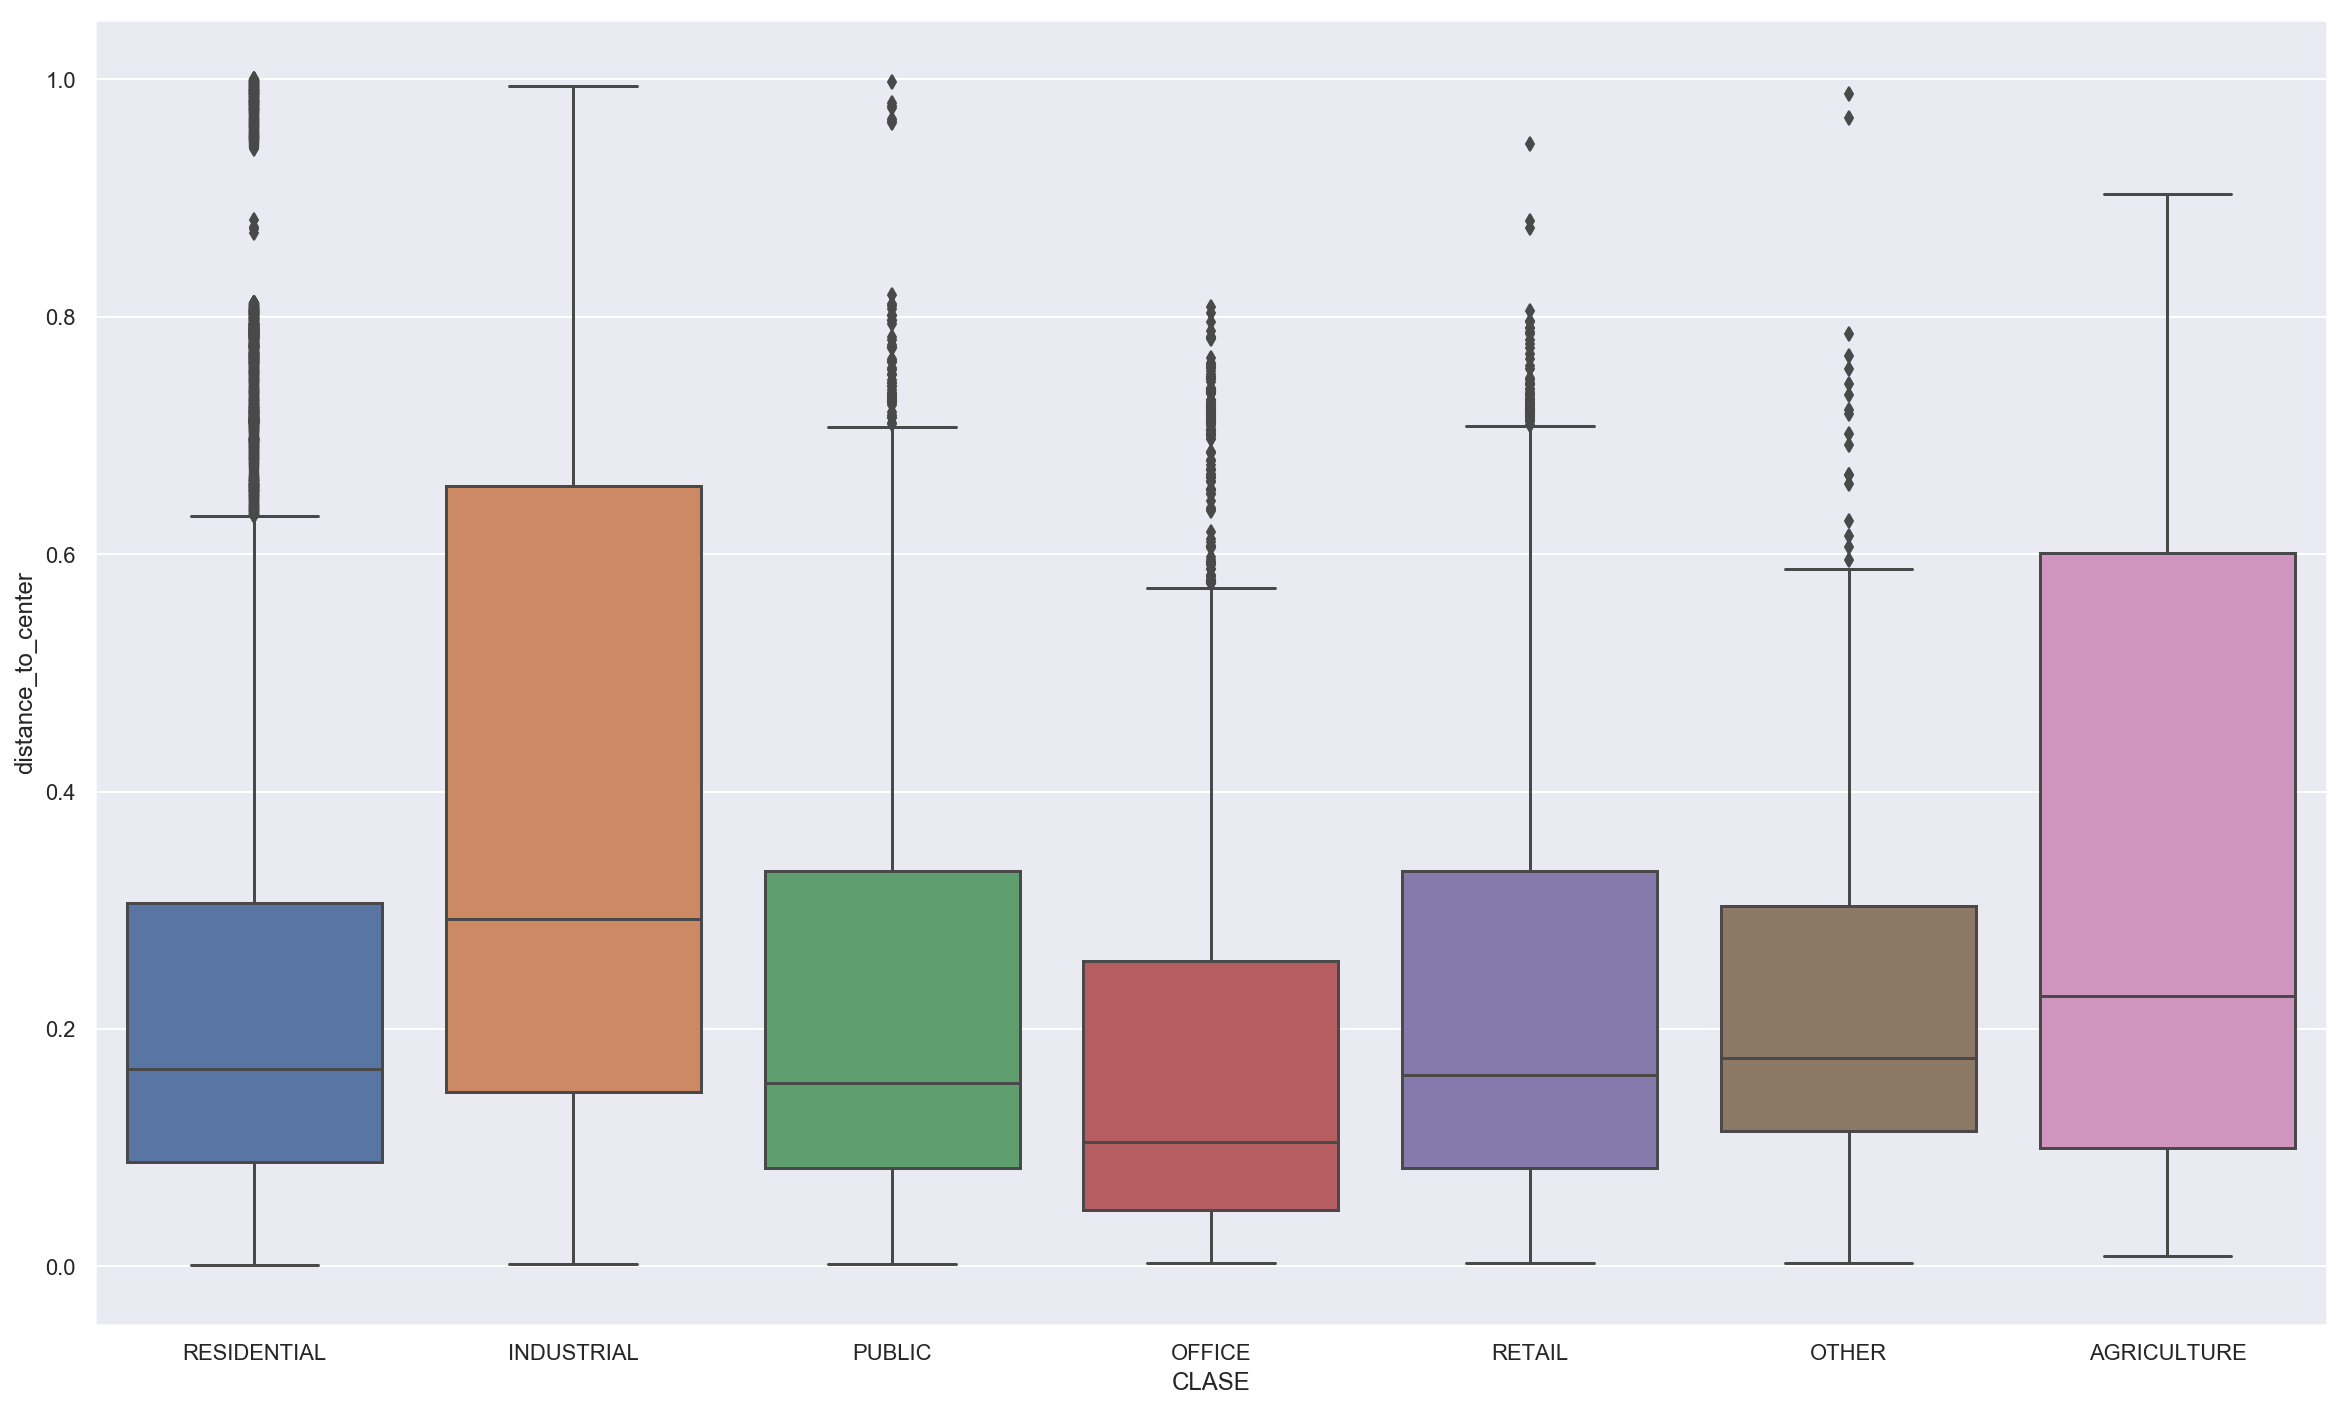

In [13]:
plt.figure(figsize=(20,12))
sns.boxplot(x="CLASE", y="distance_to_center", data=df_modelar)

## Densidad de vecinos

# Cambiar por kneighbours porque en el test no tenemos las clases

In [14]:
def get_n_neighbours(registry, n):
    index = registry.index
    d = registry['distance_to_center']
    neighbours = df_modelar.loc[np.abs(df_modelar[~df_modelar.index.isin(index)]['distance_to_center'] - d).nsmallest(n).index]
    return neighbours['CLASE']

In [15]:
def process_density(registry, n):
    neighbours = get_n_neighbours(registry, n)
    result = neighbours.value_counts()
    for c in result.index:
        registry[c] = result[c] # / result.values.sum() Para probabilidades
    return registry

In [ ]:
index_min_distance = np.abs(
        df_modelar[~df_modelar.index.isin(['BFDE3E366A78561C'])]['distance_to_center'] - df_modelar.loc['BFDE3E366A78561C']['distance_to_center']) \
                    .nsmallest(10).index
df_modelar.loc[index_min_distance]['CLASE'].value_counts()

In [ ]:
df_modelar[(df_modelar['distance_to_center'] < df_modelar.loc['BFDE3E366A78561C']['distance_to_center']+0.001) & 
           (df_modelar['distance_to_center'] > df_modelar.loc['BFDE3E366A78561C']['distance_to_center']-0.001)]['CLASE'].value_counts()

In [74]:
aux = process_density(X_test.iloc[0], 5)

In [75]:
aux

distance_to_center    0.118204
RESIDENTIAL           3.000000
OFFICE                1.000000
PUBLIC                1.000000
Name: 45C44E3E0FECCB0E, dtype: float64

In [ ]:
aux = df_modelar[df_modelar.CLASE=='RESIDENTIAL'][:200].apply(lambda r: process_density(r, 4), axis=1)

In [ ]:
aux[df_modelar.CLASE.unique()].sum()

In [155]:
from sklearn.neighbors import KNeighborsClassifier

X = df_modelar[['X', 'Y']].copy()
y = df_modelar['CLASE'].copy()

n = 5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)
neigh = KNeighborsClassifier(n_neighbors=n, weights='uniform')
neigh.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [157]:
y_pred = neigh.predict(X_test)
y_prob = neigh.predict_proba(X_test)

In [159]:
from sklearn.metrics import accuracy_score, classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 AGRICULTURE       0.74      0.35      0.48        82
  INDUSTRIAL       0.74      0.51      0.60      1144
      OFFICE       0.54      0.14      0.22       466
       OTHER       0.57      0.06      0.11       340
      PUBLIC       0.60      0.09      0.16       759
 RESIDENTIAL       0.91      0.99      0.95     22995
      RETAIL       0.62      0.07      0.13       533

    accuracy                           0.90     26319
   macro avg       0.67      0.32      0.38     26319
weighted avg       0.87      0.90      0.87     26319



In [160]:
y_prob

array([[0. , 0. , 0. , ..., 0. , 1. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0.8, 0. ],
       [0. , 0. , 0. , ..., 0. , 1. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0.2, 0.8, 0. ],
       [0. , 0.2, 0. , ..., 0. , 0.8, 0. ],
       [0. , 0. , 0. , ..., 0. , 0.6, 0. ]])

In [161]:
aux = pd.DataFrame(y_prob*n, columns=neigh.classes_, index=X_test.index)

In [162]:
aux_2 = X_test.merge(aux, on='ID', how='inner')

In [163]:
aux_2[neigh.classes_].sum()

AGRICULTURE       245.0
INDUSTRIAL       5238.0
OFFICE           2074.0
OTHER            1561.0
PUBLIC           3335.0
RESIDENTIAL    116525.0
RETAIL           2617.0
dtype: float64

In [164]:
aux_2[(aux_2['AGRICULTURE']>0) & (aux_2['RETAIL']>0)]

,X,Y,AGRICULTURE,INDUSTRIAL,OFFICE,OTHER,PUBLIC,RESIDENTIAL,RETAIL
ID,,,,,,,,,
1F7405406C97A66E,2213836374,166038335,1.0,0.0,0.0,0.0,1.0,2.0,1.0
C4350D42D4EC39EE,2201342108,166049268,2.0,0.0,0.0,0.0,0.0,2.0,1.0
7222B2C37045CBC6,2287141056,165467900,4.0,0.0,0.0,0.0,0.0,0.0,1.0
2FDA1C767B043D8A,2213791580,166246285,3.0,0.0,0.0,0.0,1.0,0.0,1.0
87953A44CB553849,2155835149,165366649,1.0,1.0,0.0,0.0,0.0,2.0,1.0
A1E44EBDADE07587,2213194739,166365659,3.0,0.0,0.0,0.0,1.0,0.0,1.0
27491224569C0B13,2222365044,166259771,1.0,1.0,2.0,0.0,0.0,0.0,1.0
224EB1A67E4B2B26,2139727383,165850076,1.0,1.0,0.0,0.0,0.0,2.0,1.0
ED0256DBA13D7CB7,2217634957,165988120,3.0,0.0,0.0,0.0,0.0,1.0,1.0


In [145]:
aux_2.iloc[0]

X              2.219282e+09
Y              1.656013e+08
AGRICULTURE    0.000000e+00
INDUSTRIAL     0.000000e+00
OFFICE         0.000000e+00
OTHER          0.000000e+00
PUBLIC         0.000000e+00
RESIDENTIAL    1.000000e+00
RETAIL         0.000000e+00
Name: 45C44E3E0FECCB0E, dtype: float64

---

In [169]:
predict = neigh.predict_proba(df_modelar[['X', 'Y']])

In [171]:
aux = pd.DataFrame(predict*n, columns=[ 'C_'+c for c in neigh.classes_ ], index=df_modelar.index)
df_modelar = df_modelar.merge(aux, on='ID', how='inner')

In [174]:
df_modelar[df_modelar['C_RESIDENTIAL'] == 0].head()

,X,Y,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,Q_R_4_0_7,...,CADASTRALQUALITYID,CLASE,distance_to_center,C_AGRICULTURE,C_INDUSTRIAL,C_OFFICE,C_OTHER,C_PUBLIC,C_RESIDENTIAL,C_RETAIL
ID,,,,,,,,,,,,,,,,,,,,,
1651F739A134EBA5,2267642951,165929091,0.001099,454.999338,573.005005,668.002612,752.999573,853.000122,1005.999158,1201.701685,...,3.0,INDUSTRIAL,0.667046,0.0,3.0,0.0,0.0,0.0,0.0,2.0
56F6582774B1F6D0,2195369233,165742204,0.000002,231.701132,364.409589,504.999207,639.999060,776.001587,922.001599,1093.998840,...,3.0,PUBLIC,0.153178,0.0,0.0,0.0,0.0,1.0,0.0,4.0
709C5E7A5C666EDF,2188630957,165280208,0.000014,633.000177,725.999939,804.000043,886.997424,980.000610,1083.000000,1205.999426,...,3.0,INDUSTRIAL,0.229666,0.0,4.0,1.0,0.0,0.0,0.0,0.0
18582CEDDDC7DBFD,2262347937,165626508,0.000035,584.000409,717.000000,859.998175,1016.000500,1205.998169,1459.001050,1728.995251,...,5.0,OFFICE,0.606945,0.0,2.0,2.0,1.0,0.0,0.0,0.0
60D1796FDDEDE6C4,2143677891,165455306,0.000000,274.999353,416.001074,561.002997,706.001086,862.001343,1040.000391,1266.006592,...,6.0,INDUSTRIAL,0.739794,0.0,4.0,1.0,0.0,0.0,0.0,0.0


In [215]:
df_modelar.drop(columns=['X', 'Y', 'C_RESIDENTIAL'], inplace=True)

In [216]:
#Transformación que se le va a aplicar a las columnas numéricas
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                             ('scaler', StandardScaler())])

#Transformador que se aplica a cada una de las columnas en función a lo declarado previamente
df_minsait_trans = ColumnTransformer(transformers=[('num', num_transformer, df_modelar.select_dtypes(include=np.number).columns.tolist())])

In [217]:
df_modelar['SUBCLASE'] = (df_modelar['CLASE'] == 'RESIDENTIAL').astype(int)

In [218]:
#Para nuestro primer modelo vamos a usar todas las variables
X = df_modelar.drop(columns=['CLASE', 'SUBCLASE']).copy()
y = df_modelar['SUBCLASE'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)

In [219]:
import xgboost as xgb
rfc_p_model = xgb.XGBClassifier(random_state=10)

parameters = {
    'clas__max_depth': [10, 20, 30],
    'clas__scale_pos_weight': [1]
}

minsait_pipe_rfc_p = Pipeline(steps=[('prep', df_minsait_trans), ('clas', rfc_p_model)])

GSR_p = GridSearchCV(minsait_pipe_rfc_p, parameters, cv=5, n_jobs=-1, scoring='f1', refit=True, verbose=1)
GSR_p.fit(X_train, y_train)
    
print("Mejor score: ", GSR_p.best_score_)
print("Mejore configuración de parámetros: ", GSR_p.best_params_)

minsait_pipe_rfc_p = GSR_p.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.2min finished


Mejor score:  0.9671968946733982
Mejore configuración de parámetros:  {'clas__max_depth': 10, 'clas__scale_pos_weight': 1}


In [189]:
def show_results(y, y_pred):
    sns.heatmap(confusion_matrix(y, y_pred), square=True, annot=True, fmt='d', cbar=True, cmap=plt.cm.Blues)
    plt.ylabel('Clase real')
    plt.xlabel('Predicción');
    plt.gca().set_ylim(2.0, 0)
    plt.show()
    print("Resultados")
    print('Accuracy: {}'.format(round(accuracy_score(y, y_pred), 3)))

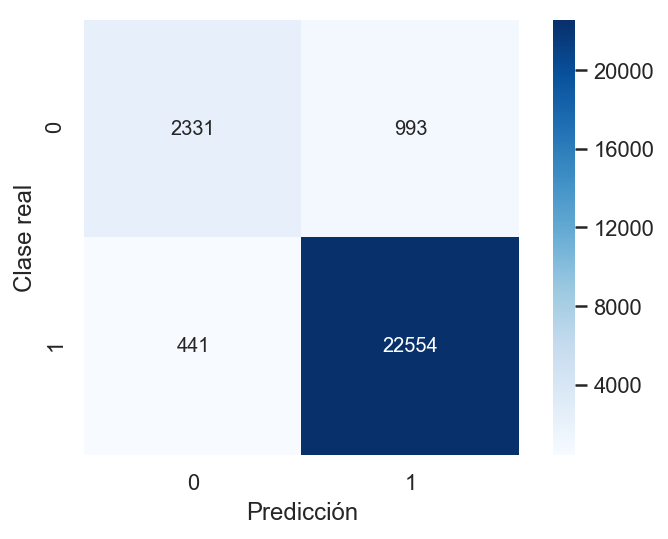

Resultados
Accuracy: 0.946


In [220]:
y_pred = minsait_pipe_rfc_p.predict(X_test)
show_results(y_test, y_pred)

In [221]:
minsait_pipe_rfc_p['clas'].feature_importances_

array([0.00568256, 0.00506585, 0.0048426 , 0.00621244, 0.00416929,
       0.00582949, 0.00641969, 0.00563303, 0.00501169, 0.00505601,
       0.00429077, 0.00451793, 0.00548287, 0.00816513, 0.00478125,
       0.00535773, 0.0068514 , 0.0074497 , 0.00533676, 0.00496819,
       0.00617027, 0.0050062 , 0.0045673 , 0.00470247, 0.00494105,
       0.00479522, 0.00662689, 0.00513371, 0.00642668, 0.00494653,
       0.00506368, 0.00696943, 0.00469419, 0.00493533, 0.00585875,
       0.00574741, 0.00653144, 0.00564039, 0.00443005, 0.00609979,
       0.00538434, 0.00557865, 0.00458738, 0.00455603, 0.02461608,
       0.00652756, 0.00935537, 0.00770226, 0.00479392, 0.00558949,
       0.00922727, 0.01132894, 0.00464086, 0.02961832, 0.2989236 ,
       0.05614467, 0.08107433, 0.102416  , 0.10752382], dtype=float32)

In [222]:
X_test.columns

Index(['Q_R_4_0_0', 'Q_R_4_0_1', 'Q_R_4_0_2', 'Q_R_4_0_3', 'Q_R_4_0_4',
       'Q_R_4_0_5', 'Q_R_4_0_6', 'Q_R_4_0_7', 'Q_R_4_0_8', 'Q_R_4_0_9',
       'Q_R_4_1_0', 'Q_G_3_0_0', 'Q_G_3_0_1', 'Q_G_3_0_2', 'Q_G_3_0_3',
       'Q_G_3_0_4', 'Q_G_3_0_5', 'Q_G_3_0_6', 'Q_G_3_0_7', 'Q_G_3_0_8',
       'Q_G_3_0_9', 'Q_G_3_1_0', 'Q_B_2_0_0', 'Q_B_2_0_1', 'Q_B_2_0_2',
       'Q_B_2_0_3', 'Q_B_2_0_4', 'Q_B_2_0_5', 'Q_B_2_0_6', 'Q_B_2_0_7',
       'Q_B_2_0_8', 'Q_B_2_0_9', 'Q_B_2_1_0', 'Q_NIR_8_0_0', 'Q_NIR_8_0_1',
       'Q_NIR_8_0_2', 'Q_NIR_8_0_3', 'Q_NIR_8_0_4', 'Q_NIR_8_0_5',
       'Q_NIR_8_0_6', 'Q_NIR_8_0_7', 'Q_NIR_8_0_8', 'Q_NIR_8_0_9',
       'Q_NIR_8_1_0', 'AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3', 'GEOM_R4',
       'CONTRUCTIONYEAR', 'MAXBUILDINGFLOOR', 'CADASTRALQUALITYID',
       'distance_to_center', 'C_AGRICULTURE', 'C_INDUSTRIAL', 'C_OFFICE',
       'C_OTHER', 'C_PUBLIC', 'C_RETAIL'],
      dtype='object')

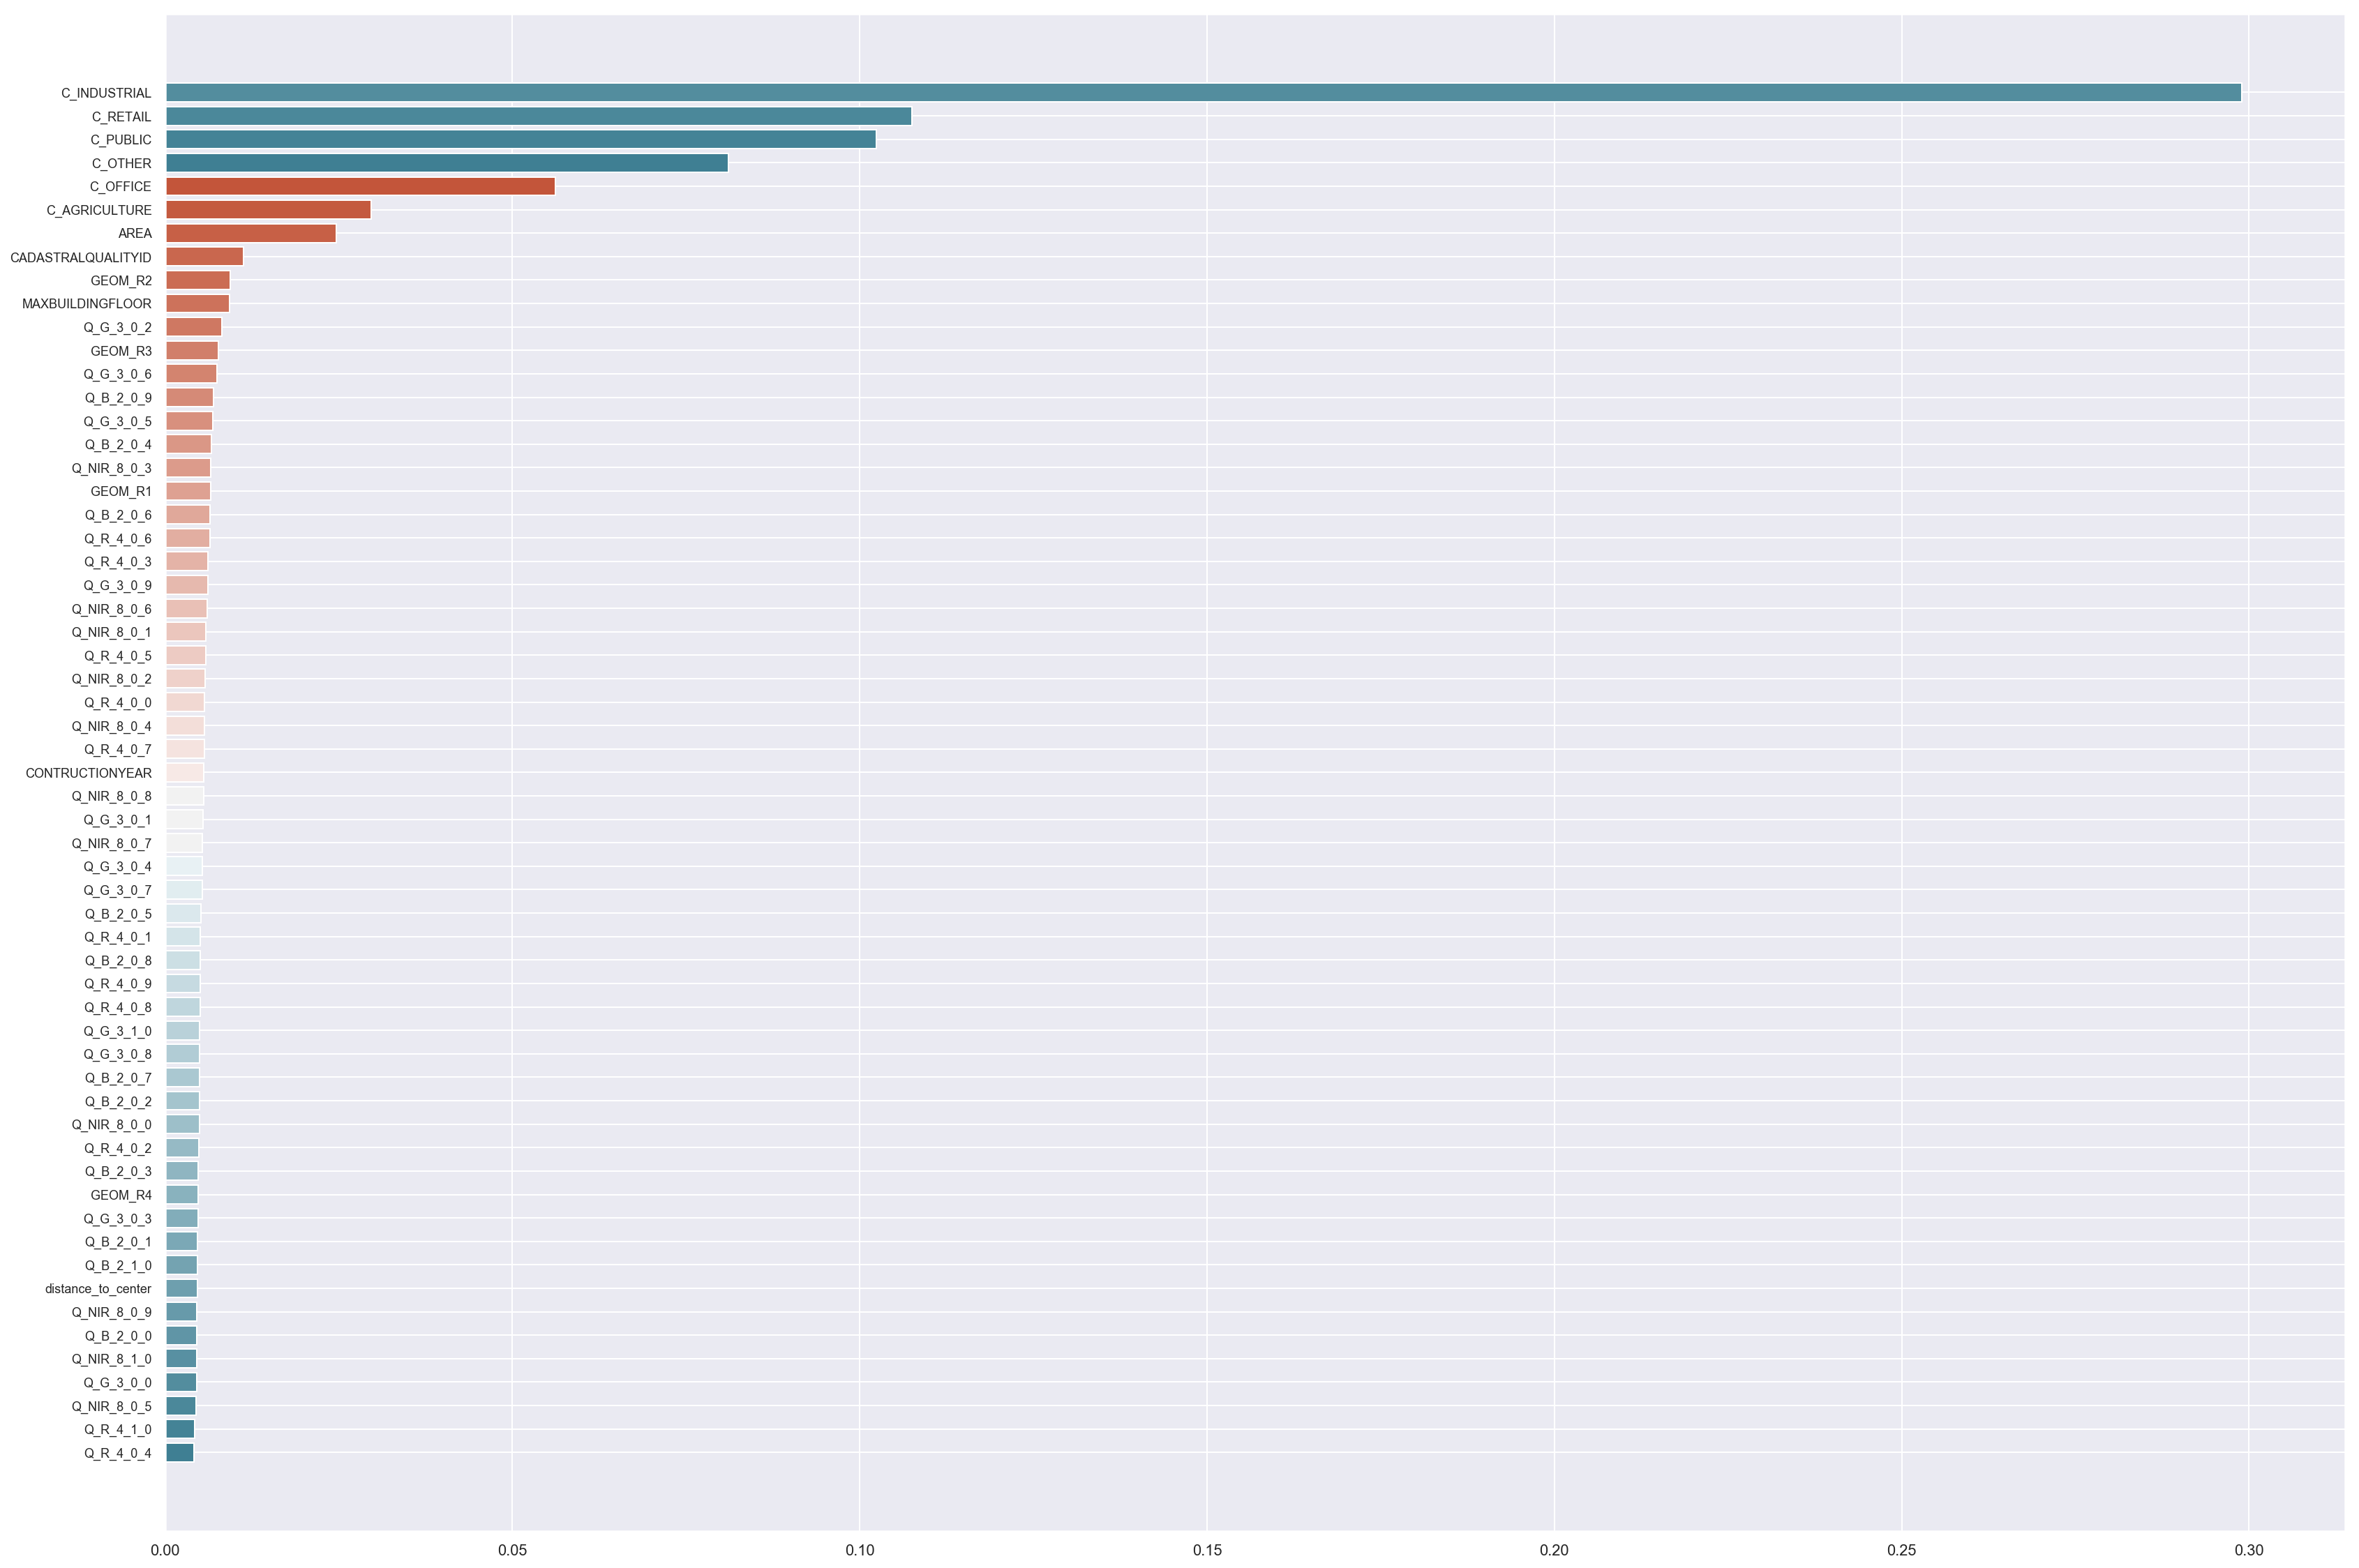

In [223]:
importances = minsait_pipe_rfc_p['clas'].feature_importances_
# Extrae los índices ordenados de menor a mayor
ranking = np.argsort(importances)

#Ahora que hemos obtenido las importancias de las variables y su ranking, vamos a dibujarlo
plt.figure(figsize=(28,20))
plt.barh(range(df_modelar.shape[1]-2), importances[ranking],color=sns.diverging_palette(220, 20, n=55),align='center')
plt.yticks(range(df_modelar.shape[1]-2), X_test.columns[ranking], fontsize=9)
plt.show()